In [2]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):
        # 初始化图片的行列通道数
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator 判别器
        self.G = None   # generator 生成器
        self.AM = None  # adversarial model 对抗模型
        self.DM = None  # discriminator model 判别模型

    # 判别模型
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        # 定义通道数64
        depth = 64
        # dropout系数
        dropout = 0.4
        # 输入28*28*1
        input_shape = (self.img_rows, self.img_cols, self.channel)
        # 输出14*14*64
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        # 输出7*7*128
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        # 输出4*4*256
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        # 输出4*4*512
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # 全连接层
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    # 生成模型
    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        # dropout系数
        dropout = 0.4
        # 通道数256
        depth = 64*4
        # 初始平面大小设置
        dim = 7
        # 全连接层，100个的随机噪声数据，7*7*256个神经网络
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        # 把1维的向量变成3维数据(7,7,256)
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))


        # 用法和 MaxPooling2D 基本相反，比如：UpSampling2D(size=(2, 2))
        # 就相当于将输入图片的长宽各拉伸一倍，整个图片被放大了
        # 上采样，采样后得到数据格式(14,14,256)
        self.G.add(UpSampling2D()) 
        # 转置卷积，得到数据格式(14,14,128) 
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # 上采样，采样后得到数据格式(28,28,128)
        self.G.add(UpSampling2D()) 
        # 转置卷积，得到数据格式(28,28,64) 
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # 转置卷积，得到数据格式(28,28,32) 
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # 转置卷积，得到数据格式(28,28,1) 
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    # 定义判别模型
    def discriminator_model(self):
        if self.DM:
            return self.DM
        # 定义优化器
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        # 构建模型
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    # 定义对抗模型
    def adversarial_model(self):
        ### --------------------------------------###
        ### 函数功能解释，进行一个对抗模型的生成
        ### --------------------------------------###
        
        ##预判断模型存在性
        if self.AM:
            return self.AM
        # 定义优化器
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        # 构建模型
        self.AM = Sequential()
        # 在Sequential里加入生成器模型
        self.AM.add(self.generator())
        # 继续在Sequential里加入判决器
        # 即先进行生成再判决
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        # 图片的行数
        self.img_rows = 28
        # 图片的列数
        self.img_cols = 28
        # 图片的通道数
        self.channel = 1

        # 载入数据
        (x_train,y_train),(x_test,y_test) = mnist.load_data()
        # (60000,28,28)
        self.x_train = x_train/255.0
        # 改变数据格式(samples, rows, cols, channel)(60000,28,28,1)
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)

        # 实例化DCGAN类
        self.DCGAN = DCGAN()
        # 定义判别器模型
        self.discriminator =  self.DCGAN.discriminator_model()
        # 定义对抗模型
        self.adversarial = self.DCGAN.adversarial_model()
        # 定义生成器
        self.generator = self.DCGAN.generator()

    # 训练模型
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None##一开始并没有噪声
        if save_interval>0:#从第2个循环开始
            # 生成16个100维的噪声数据
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
            ## 加入随机高斯噪声 因为生成器的输入维度为100，此处即是生成16个随机数据样本，训练过后是16张图片
            
        for i in range(train_steps):#注意i从0开始取值
            # 训练判别器，提升判别能力，先对判决器进行训练
            # 随机得到一个batch的图片数据，从(0,总样本量)的集合中随机取出批次数的训练样本
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            # 随机生成一个batch的噪声数据
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            # 生成伪造的图片数据
            
            if i>0:#从第二次开始载入模型
                self.generator = load_model('generator.h5')
            else:
                pass
            
            images_fake = self.generator.predict(noise) ##借噪声以生成假图片
            # 合并一个batch的真实图片和一个batch的伪造图片
            x = np.concatenate((images_train, images_fake))##将真实训练图片与伪装图片进行合并，合并到一个数据批次中
            #已解决 # ？？？此处因为这里有一半的数据，故而准确率的理想值为0.5？？，但是感觉emm这里明明标签是正确的不该是1.0吗？
            #已解决 # ？？？如果是对抗模型的话，那也没有真实数据的输入呀，显示的是d_loss应该是这里，有点搞不明白
            # 原因：因为进行判决的时候，这里是有生成器传送过来的虚假图的，占比一半，故而如果伪造得好，即所有的图片都是（像）真
            #       所以，那一半的假值，就被当成真的来预测了，故而就只有0.5的准确率
            # 注意 这里是合并到x中，病不是合并到x_batch中，所以数据不会一直变大
            
            # 定义标签，真实数据的标签为1，伪造数据的标签为0
            # 将所有标签都标识成1，而后将后一半的假图片标识为0，
            #  即完成对所有图片的标识,
            # 这样加标签的优点，可以在每批次将噪声数据加入
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            
            # 把数据放到判别器中进行判断
            if i>0:
                self.discriminator = load_model('discriminator.h5')# 训练一次，之后开始载入数据，进行断点训练，以免突发情况，参数无法保存
            else:
                pass
            # 使用train_on_batch方法进行训练，注意这里的训练样本为x，label为刚刚生成的y，故而batch数据大小均为2倍预设值，不会越变越大
            d_loss = self.discriminator.train_on_batch(x, y) ##compile中加入了metrics，train_on_batch的返回值为一个数组，[0]为loss，[1]为metrics
            self.discriminator.save('discriminator.h5')
        # 训练对抗模型，提升生成器的造假能力 How？
        # 告诉判决器所有的都是真图（但是里面全是生成的假图片），即企图欺骗
        # 如若损失值很小，即表示假图被识别成真图很多，即生成器伪装能力很强，
        # 私以为 这样训练生成器的时候，判决器的参数也会调整
            # 标签都定义为1
            y = np.ones([batch_size, 1])
            # 因为全是真（意欲欺骗成功，此处准确率acc可理解为欺骗成功率）
            # 生成一个batch的噪声数据
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            if i>0:
                self.adversarial = load_model('adversarial.h5')
            else:
                pass
            # 训练对抗模型
            a_loss = self.adversarial.train_on_batch(noise, y)
            self.adversarial.save('adversarial.h5')
            self.generator.save('generator.h5')
            # 打印判别器的loss和准确率，以及对抗模型的loss和准确率
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1]) #存入次数，判决器的损失函数和准确率
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])#将前面的信息拼接上对抗模型（即生成器的）损失函数和准确率
            
            if 0 == i%100:
                print(log_mesg)# 输出存储的信息文本
            # 如果需要保存图片
            if save_interval>0:
                # 如若间隔值大于0（这里用以防错），用于预防间隔设定为0出现除数为零报错，为负出现计算错误
                if 0 == (i+1)%save_interval:#间隔值为零 进行图片的操作（存储）
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))

    # 保存图片
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        ### --------------------------------------------------------------------------------------------- ###
        ### 函数说明
        ### 参数save2file = False是否存储图像文件（默认为不存储） fake = True 是否显示图片为假图片
        ### samples=16 默认显示样本的数量为16 noise=None 默认没有设定生成噪声源，也可以自行设定，需要注意噪声源大小匹配样本数量
        ### 噪声这里 可以考虑默认设为高斯噪声，有一个范例的话，方便用户输入，此处应该好可以进行加强
        ### step=0 显示步数，用以生成文件名
        ### --------------------------------------------------------------------------------------------- ###
        
        filename = 'mnist.png'##设定文件名称
        
        if fake:#打开假数据开关，即显示假数据（现场利用训练好的生成器模型进行伪装，然后输出数据）
            if noise is None:#如果没有噪声，就进行噪声的生成（即进行噪声有无的判断，增加代码的健壮性）
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])#则生成样本数个随机高斯噪声
            else:#若自带了噪声
                filename = "mnist_%d.png" % step ##将文件名命名为mnist_次数.png
            # 生成伪造的图片数据
            images = self.generator.predict(noise)##生成伪装图像
            
        else:#若不开启假数据开关，即随机抽取，显示真实的样本数量
            # 获得真实图片数据，随机从样本中取出样本个数个图片
            i = np.random.randint(0, self.x_train.shape[0], samples)#次数生成随机索引
            images = self.x_train[i, :, :, :]#此处按索引取出？？？喵喵喵？还能用一个list来取值？？此处存疑

        # 设置图片大小
        plt.figure(figsize=(10,10))
        # 生成16张图片
        for i in range(images.shape[0]):# 取出样本总数的数据，即进行样本数次循环
            plt.subplot(4, 4, i+1)#由于是生成16张图片，4行4列，目前的位置是第几（由于此处的序列不从0开始，故而+1）
            # 获取一个张图片数据
            image = images[i, :, :, :]#取出第i张
            # 变成2维的图片
            image = np.reshape(image, [self.img_rows, self.img_cols])##此处取出的数据应是4维数据，[0]and[3]都是1，可以不用管直接取中间
            # 显示灰度图片
            plt.imshow(image, cmap='gray')
            # 不显示坐标轴
            plt.axis('off')
        # 保存图片
        if save2file:# 是否保存图片
            plt.savefig(filename)# 按图片名进行保存
            plt.close('all')
        # 不保存的话就显示图片
        else:
            plt.show()# 不保存 就进行显示

            
# 实例化网络的类
mnist_dcgan = MNIST_DCGAN()
# 训练模型
mnist_dcgan.train(train_steps=500,batch_size=256, save_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


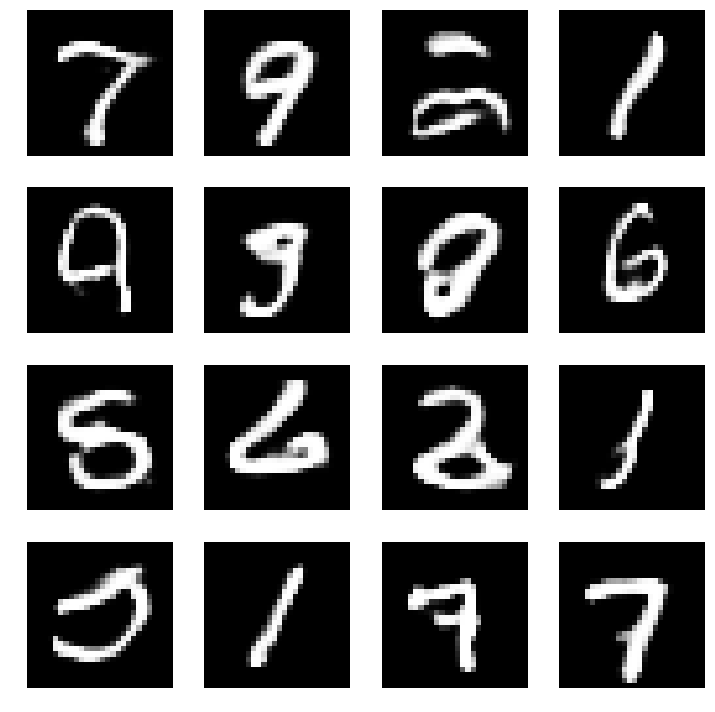

In [10]:
mnist_dcgan.plot_images(fake=True)
# 显示伪装假的数据

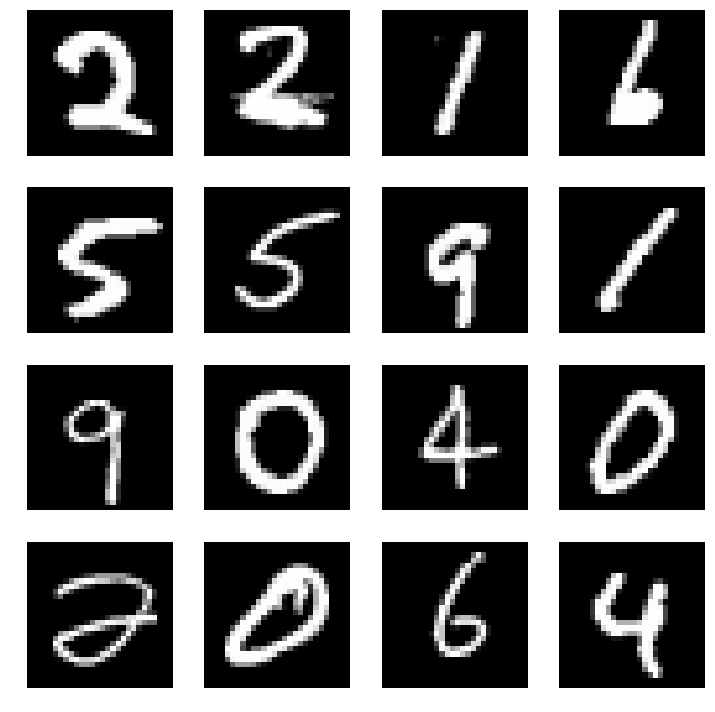

In [9]:
mnist_dcgan.plot_images(fake=False)
#显示真实样本数据

In [12]:
mnist_dcgan.generator.save('generator.h5')
mnist_dcgan.discriminator.save('discriminator.h5')
mnist_dcgan.adversarial.save('adversarial.h5')